In [3]:
!pip install transformers
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 5.1 MB/s 
     |████████████████████████████████| 46 kB 4.9 MB/s 
     |████████████████████████████████| 64 kB 2.9 MB/s 
     |████████████████████████████████| 99 kB 11.0 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=1af01f2ddfdb75161109cb984ce3ff60bc68425a16ea9682763a44107424aded
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
Successfully built py-cpuinfo


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertConfig, TFBertForSequenceClassification
import tensorflow as tf

from sklearn.model_selection import train_test_split
from codecarbon import EmissionsTracker

pd.options.display.max_colwidth = None
%matplotlib inline

## Importing data sets

In [223]:
#importint datasets

df_train = pd.read_csv('data/sentiment/train.txt', header = None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('data/sentiment/test.txt', header = None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_valid = pd.read_csv('data/sentiment/val.txt', header = None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')

df_valid2 = df_valid

In [166]:
#train dataset
print(df_train.shape)
df_train.head()

(16000, 2)


,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love
4,i am feeling grouchy,anger


In [167]:
#test dataset
print(df_test.shape)
df_test.head()

(2000, 2)


,Input,Sentiment
0,im feeling rather rotten so im not very ambitious right now,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i don t ever want her to feel like i m ashamed with her,sadness
3,i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived,joy
4,i was feeling a little vain when i did this one,sadness


In [168]:
#Valid dataset
print(df_valid.shape)
df_valid.head()

(2000, 2)


,Input,Sentiment
0,im feeling quite sad and sorry for myself but ill snap out of it soon,sadness
1,i feel like i am still looking at a blank canvas blank pieces of paper,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [169]:
#Train distributions targets sentiment
df_train.Sentiment.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Sentiment, dtype: int64

In [170]:
#Encoding sentiments
encoded_dict = {'anger':0,'fear':1, 'joy':2, 'love':3, 'sadness':4, 'surprise':5}
df_train['Sentiment'] = df_train.Sentiment.map(encoded_dict)
df_test['Sentiment'] = df_test.Sentiment.map(encoded_dict)
df_valid['Sentiment'] = df_valid.Sentiment.map(encoded_dict)

In [171]:
df_train.head()

,Input,Sentiment
0,i didnt feel humiliated,4
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,4
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,3
4,i am feeling grouchy,0


In [172]:
df_test.head()

,Input,Sentiment
0,im feeling rather rotten so im not very ambitious right now,4
1,im updating my blog because i feel shitty,4
2,i never make her separate from me because i don t ever want her to feel like i m ashamed with her,4
3,i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived,2
4,i was feeling a little vain when i did this one,4


In [173]:
df_valid.head()

,Input,Sentiment
0,im feeling quite sad and sorry for myself but ill snap out of it soon,4
1,i feel like i am still looking at a blank canvas blank pieces of paper,4
2,i feel like a faithful servant,3
3,i am just feeling cranky and blue,0
4,i can have for a treat or if i am feeling festive,2


In [174]:
X_train = df_train.Input
y_train = df_train.Sentiment

X_test = df_test.Input
y_test = df_test.Sentiment

X_valid = df_valid.Input
y_valid = df_valid.Sentiment

## Preparing DATA

In [182]:
#Tokenize

nombre_modelo = 'bert-base-multilingual-uncased'

tokenizer = BertTokenizer.from_pretrained(nombre_modelo)
train_encodings = tokenizer(X_train.to_list(), truncation=True, padding=True, return_tensors="tf")

In [183]:
MAX_SEQUENCE_LENGTH=train_encodings['input_ids'].shape[1]

test_encodings = tokenizer(X_test.to_list(), truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors="tf")

valid_encondings = tokenizer(X_valid.to_list(), truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors="tf")

In [184]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))
valid_dataset = tf.data.Dataset.from_tensor_slices((
    dict(valid_encondings),
    y_valid
))



## Fine Tuning with BERT

In [185]:
N_SENTIMENT = len(encoded_dict)

#definimos modelo de clasificación
config = BertConfig.from_pretrained(nombre_modelo, hidden_dropout_prob=0.2, num_labels=N_SENTIMENT)

model = TFBertForSequenceClassification.from_pretrained(nombre_modelo, config=config)
model.bert.trainable = True #Freeze BERT layers

# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  167356416 
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
Total params: 167,361,030
Trainable params: 167,361,030
Non-trainable params: 0
_________________________________________________________________


In [186]:
#main loop
batch_size=32
N_EPOCHS = 2
history=model.fit(train_dataset.batch(batch_size), epochs=N_EPOCHS, batch_size=batch_size, validation_data=test_dataset.batch(batch_size))

Epoch 1/2
500/500 [==============================] - 219s 386ms/step - loss: 0.7956 - accuracy: 0.7115 - val_loss: 0.2381 - val_accuracy: 0.9120
Epoch 2/2
500/500 [==============================] - 189s 377ms/step - loss: 0.2267 - accuracy: 0.9172 - val_loss: 0.1899 - val_accuracy: 0.9220


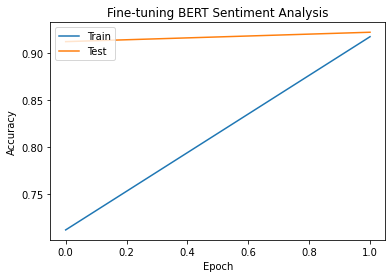

In [187]:
#Ploting results

import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Fine-tuning BERT Sentiment Analysis')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluation

list

In [189]:
#Training evaluation
score,acc = model.evaluate(train_dataset.batch(batch_size), verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

500/500 - 68s - loss: 0.1239 - accuracy: 0.9452 - 68s/epoch - 137ms/step
score: 0.12
acc: 0.95


In [192]:
#Test evaluation
score,acc = model.evaluate(test_dataset.batch(batch_size), verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

63/63 - 8s - loss: 0.1899 - accuracy: 0.9220 - 8s/epoch - 131ms/step
score: 0.19
acc: 0.92


In [193]:
#Valid evaluation
score,acc = model.evaluate(valid_dataset.batch(batch_size), verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

63/63 - 9s - loss: 0.1779 - accuracy: 0.9280 - 9s/epoch - 136ms/step
score: 0.18
acc: 0.93


## Predictions

In [250]:

# function to return key for any value
def get_key(val):
    for key, value in encoded_dict.items():
         if val == value:
             return key
 
    return "key doesn't exist"

In [251]:
predict = model.predict(valid_dataset.batch(batch_size))

In [252]:
predict_proba = tf.nn.softmax(predict.logits)
predict_classes = np.argmax(predict_proba, 1)
predict_classes

array([4, 4, 2, ..., 2, 2, 2])

In [253]:
df_valid2['predicted'] = [get_key(x) for x in predict_classes]

In [281]:
df_valid2.head(15)

,Input,Sentiment,predicted
0,im feeling quite sad and sorry for myself but ill snap out of it soon,sadness,sadness
1,i feel like i am still looking at a blank canvas blank pieces of paper,sadness,sadness
2,i feel like a faithful servant,love,joy
3,i am just feeling cranky and blue,anger,anger
4,i can have for a treat or if i am feeling festive,joy,joy
5,i start to feel more appreciative of what god has done for me,joy,joy
6,i am feeling more confident that we will be able to take care of this baby,joy,joy
7,i feel incredibly lucky just to be able to talk to her,joy,joy
8,i feel less keen about the army every day,joy,joy
9,i feel dirty and ashamed for saying that,sadness,sadness


## Random Sentences Prediction

In [277]:
#Simple text prediction
sentences = ["im feeling quite sad and sorry for myself but ill snap out of it soon", 
             "Today is my cousin's birthday party, I'm happy now", "I'm so lonely today, need some company", 
             "im updating my blog because i feel shitty", "I'm furious now, need to punch someone"]

In [278]:
predict_sentences = tokenizer(sentences, truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors="tf")
predict_dataset = tf.data.Dataset.from_tensor_slices((
    dict(predict_sentences),
))

In [279]:
predict = model.predict(predict_dataset.batch(batch_size))
predict_proba = tf.nn.softmax(predict.logits)
predict_classes = np.argmax(predict_proba, 1)

In [280]:
for i in range(len(predict_classes)):
  print(sentences[i],": ",get_key(predict_classes[i]))

im feeling quite sad and sorry for myself but ill snap out of it soon :  sadness
Today is my cousin's birthday party, I'm happy now :  joy
I'm so lonely today, need some company :  sadness
im updating my blog because i feel shitty :  sadness
I'm furious now, need to punch someone :  anger
